### Image Data Augmentation for Model Training

In this notebook, we'll implement various data augmentation techniques to enhance our image dataset. Data augmentation helps improve model robustness by creating variations of existing images, allowing the model to learn from a more diverse set of examples without requiring additional data collection.

1. Setup and Data Loading

First, let's import the necessary libraries and load our dataset.

In [ ]:
# Import necessary libraries
import concurrent
import os
import random

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [4]:
# Load the dataset
df = pd.read_csv('../data/pages_processed.csv')
print(f"Dataset loaded with {len(df)} images")

df.head()

Dataset loaded with 1256 images


,Image,Type
0,data/img_processed/prudentia_herba_decorus_8fa...,vesta
1,data/img_processed/salus_concordia_nubes_a8be0...,vesta
2,data/img_processed/tempus_arbor_sapor_b6bf900d...,vesta
3,data/img_processed/altus_constantia_sapor_9326...,vesta
4,data/img_processed/bellum_fortis_claritas_5959...,vesta


2. Creating Augmentation Pipeline

Now we'll define our augmentation pipeline using the Albumentations library. This library provides efficient implementations of various image transformations.

In [30]:
# Define the augmentation pipeline
augmentation = A.Compose([
    # Spatial transformations
    A.Rotate(limit=15, p=0.7),                               # Rotation
    A.RandomScale(scale_limit=(0.9, 1.2), p=0.6),            # Slight zoom in/out
    A.Affine(translate_percent=0.05, p=0.6),                 # Slight shift to keep objects in view
    A.HorizontalFlip(p=0.5),                                 # Horizontal flip with 50% probability
    
    # Color/intensity transformations
    A.RandomBrightnessContrast(
        brightness_limit=0.2, 
        contrast_limit=0.2, 
        p=0.6
    ),                                                        # Subtle brightness/contrast changes
    A.GaussianBlur(blur_limit=3, p=0.3),                      # Blur
    A.Sharpen(alpha=(0.1, 0.3), lightness=(0.5, 1.0), p=0.4)  # Enhance edges to maintain clarity
])

4. Augmentation Function

Let's create a function to apply augmentations to our images and save the results.

In [31]:
def load_image(image_path):
    """Load an image from path and convert to RGB"""
    img = cv2.imread(image_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def augment_and_save(image_path, output_dir, num_augmentations=5, image_type=None):
    """
    Apply augmentations to an image and save the results
    
    Args:
        image_path: Path to the original image
        output_dir: Directory to save augmented images
        num_augmentations: Number of augmented versions to create
        image_type: Class/type of the image for filename
    
    Returns:
        List of paths to augmented images
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Load image
    img = load_image(image_path)
    
    # Get original filename without extension
    base_name = os.path.basename(image_path)
    file_name = os.path.splitext(base_name)[0]
    
    augmented_paths = []
    
    # Generate augmented versions
    for i in range(num_augmentations):
        # Apply augmentations
        augmented = augmentation(image=img)
        aug_img = augmented['image']
        
        # Create new filename
        new_filename = f"{file_name}_aug_{i}.jpg"
        if image_type:
            new_filename = f"{image_type}_{file_name}_aug_{i}.jpg"
            
        # Save path
        save_path = os.path.join(output_dir, new_filename)
        
        # Save augmented image
        plt.imsave(save_path, aug_img)
        augmented_paths.append(save_path)
        
    return augmented_paths

5. Processing the Dataset

Now let's apply our augmentation pipeline to the entire dataset. We'll create multiple augmented versions of each image.

In [ ]:
# Calculate augmentations needed for each class to balance the dataset
class_counts = df['Type'].value_counts()
target_count = 850  # Slightly higher than the current max (852 for 'aureus' - after testing)
class_multipliers = {}

for class_name, count in class_counts.items():
    # Calculate how many augmentations needed per original image
    augmentations_needed = max(1, int(np.ceil((target_count - count) / count)))
    class_multipliers[class_name] = augmentations_needed

print("Augmentations per class:")
for class_name, multiplier in class_multipliers.items():
    print(f"{class_name}: {multiplier} augmentations per original image")

Augmentations per class:
aureus: 5 augmentations per original image
cicero: 6 augmentations per original image
roman: 6 augmentations per original image
vesta: 7 augmentations per original image
senatus: 7 augmentations per original image
colosseum: 7 augmentations per original image
augustus: 7 augmentations per original image
consul: 7 augmentations per original image
trajan: 8 augmentations per original image
laurel: 9 augmentations per original image
forum: 9 augmentations per original image


In [33]:
# Define output directory for augmented images
output_dir = '../data/img_augmented'

def process_image(row):
    image_path = row['Image']
    image_type = row['Type']
    
    # Get number of augmentations for this class
    num_augs = class_multipliers[image_type]
    
    # Augment and save images
    new_paths = augment_and_save(
        f"../{image_path}", 
        output_dir, 
        num_augmentations=num_augs,
        image_type=image_type
    )
    
    return new_paths, [image_type] * len(new_paths)

# Process all images in the dataset using multithreading
augmented_image_paths = []
augmented_types = []

with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    futures = [executor.submit(process_image, row) for _, row in df.iterrows()]
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Augmenting Images"):
        new_paths, new_types = future.result()
        augmented_image_paths.extend(new_paths)
        augmented_types.extend(new_types)

# Create a new dataframe with original and augmented images
original_data = {
    'Image': df['Image'].tolist(),
    'Type': df['Type'].tolist(),
    'Augmented': ['Original'] * len(df)
}

augmented_data = {
    'Image': augmented_image_paths,
    'Type': augmented_types,
    'Augmented': ['Augmented'] * len(augmented_image_paths)
}

# Combine original and augmented data
all_images_df = pd.DataFrame({
    'Image': original_data['Image'] + augmented_data['Image'],
    'Type': original_data['Type'] + augmented_data['Type'],
    'Augmented': original_data['Augmented'] + augmented_data['Augmented']
})

# Save the new dataframe
all_images_df.to_csv('../data/augmented_dataset.csv', index=False)

print(f"Original dataset: {len(df)} images")
print(f"Augmented images: {len(augmented_image_paths)} images")
print(f"Total dataset size after augmentation: {len(all_images_df)} images")

Augmenting Images:   0%|          | 0/1256 [00:00<?, ?it/s]

Original dataset: 1256 images
Augmented images: 8698 images
Total dataset size after augmentation: 9954 images


6. Visualizing Augmentations

Let's visualize the original images alongside their augmented versions to better understand the transformations.

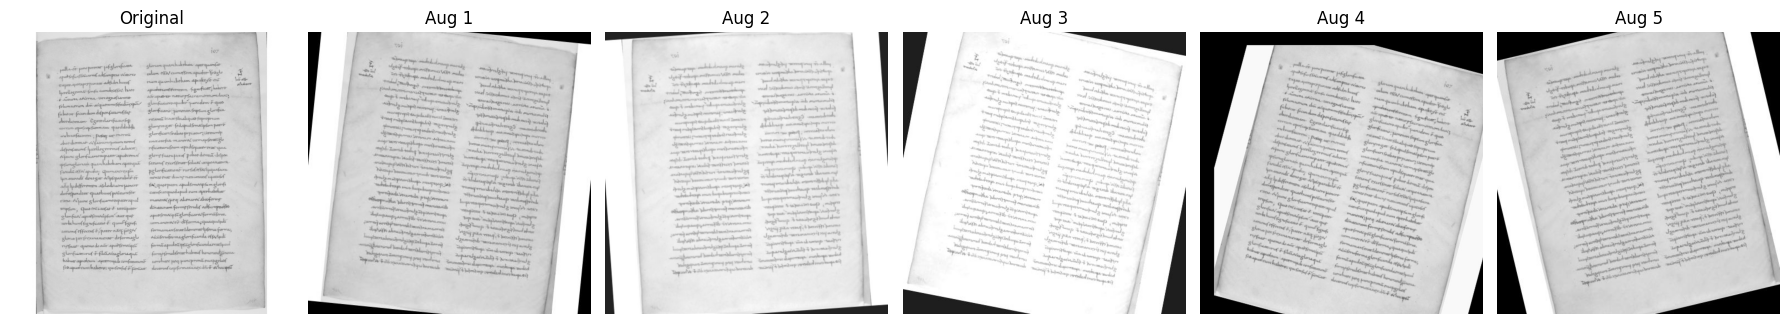

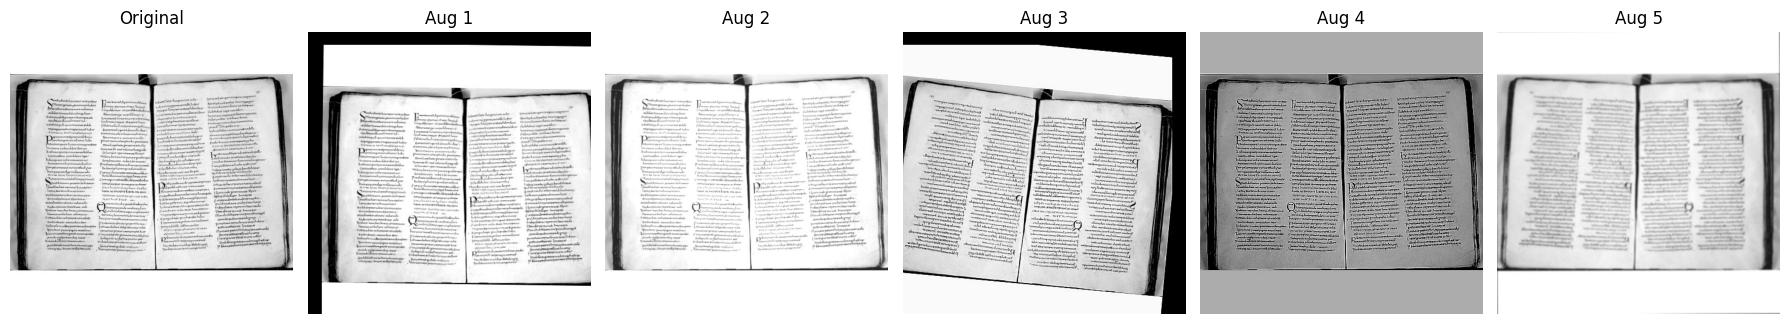

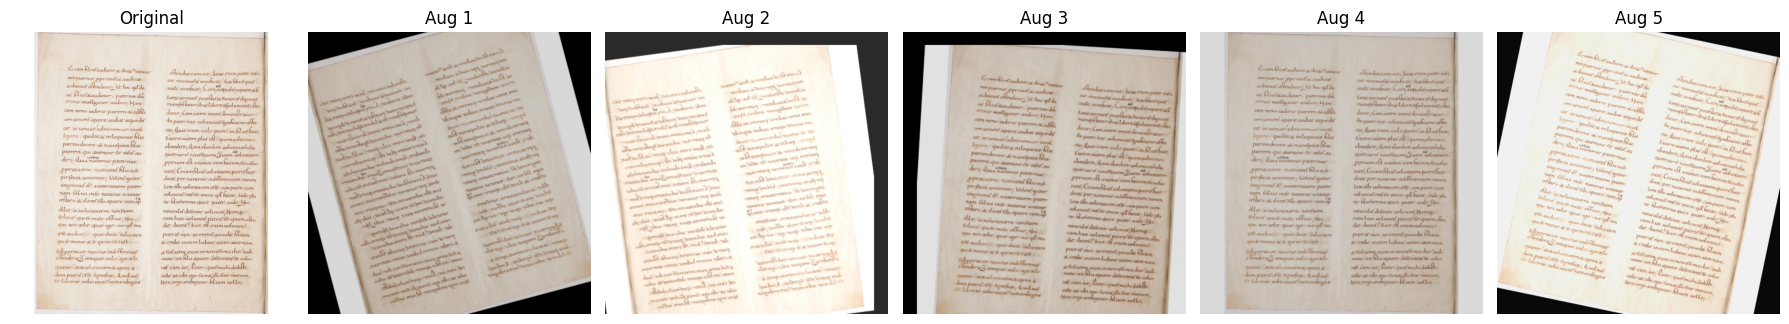

In [34]:
# Select a few original images
sample_originals = df['Image'].iloc[:3].tolist()

# Display original and augmented versions
for original_path in sample_originals:
    # Get base filename
    base_name = os.path.splitext(os.path.basename(original_path))[0]
    
    # Find augmented versions
    aug_versions = [p for p in augmented_image_paths if base_name in p][:5]  # Get up to 5 augmentations
    
    # Plot original and augmentations
    plt.figure(figsize=(18, 4))
    
    # Original image
    plt.subplot(1, 6, 1)
    original_img = load_image(f"../{original_path}")
    plt.imshow(original_img)
    plt.title('Original')
    plt.axis('off')
    
    # Augmented versions
    for i, aug_path in enumerate(aug_versions):
        plt.subplot(1, 6, i+2)
        aug_img = load_image(aug_path)
        plt.imshow(aug_img)
        plt.title(f'Aug {i+1}')
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

7. Augmentation Effects Visualization

Let's visualize each specific augmentation technique individually to better understand their effects.

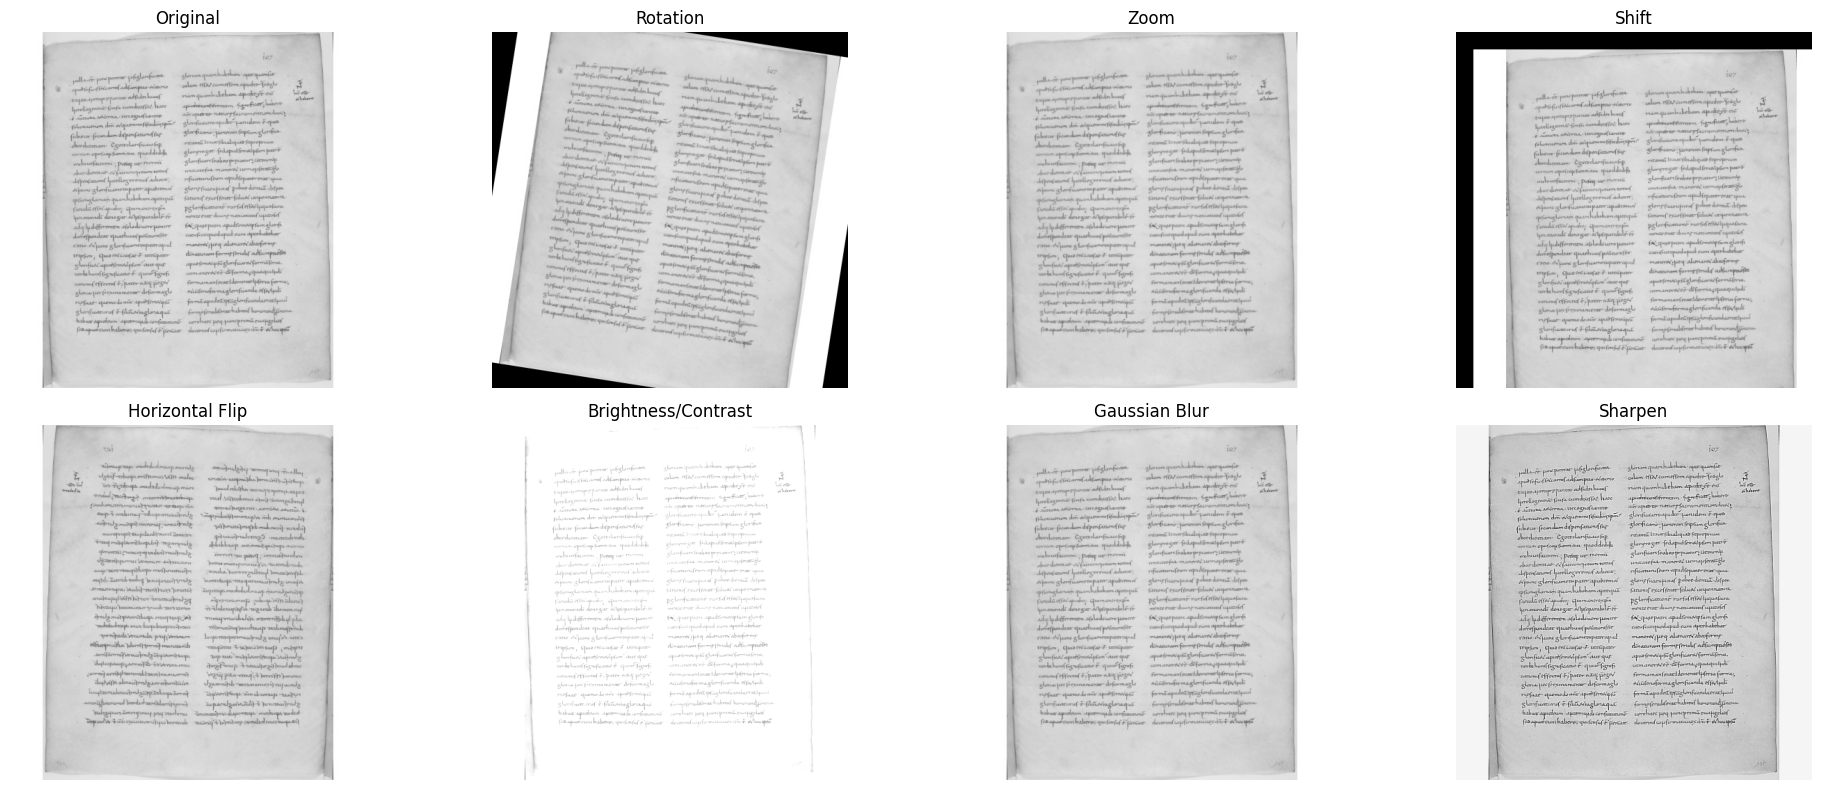

In [35]:
# Function to visualize individual augmentations
def visualize_individual_augmentations(image_path):
    """Show the effect of each augmentation technique individually"""
    # Load image
    img = load_image(f"../{image_path}")
    
    # Define individual augmentations
    augmentations = {
        'Original': None,
        'Rotation': A.Rotate(limit=15, p=1.0),
        'Zoom': A.RandomScale(scale_limit=(0.9, 1.2), p=1.0),
        'Shift': A.Affine(translate_percent=0.05, p=1.0),
        'Horizontal Flip': A.HorizontalFlip(p=1.0),
        'Brightness/Contrast': A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),  
        'Gaussian Blur': A.GaussianBlur(blur_limit=3, p=1.0),
        'Sharpen': A.Sharpen(alpha=(0.1, 0.3), lightness=(0.5, 1.0), p=1.0)
    }

    
    # Plot each augmentation
    plt.figure(figsize=(20, 8))
    for i, (name, aug) in enumerate(augmentations.items()):
        plt.subplot(2, 4, i+1)
        
        if aug is None:
            plt.imshow(img)
        else:
            augmented = aug(image=img)
            plt.imshow(augmented['image'])
            
        plt.title(name)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Visualize augmentations on a sample image
sample_image = df['Image'].iloc[0]
visualize_individual_augmentations(sample_image)

8. Analysis of Augmented Dataset

Let's analyze our augmented dataset to understand its distribution and ensure we have a balanced dataset.

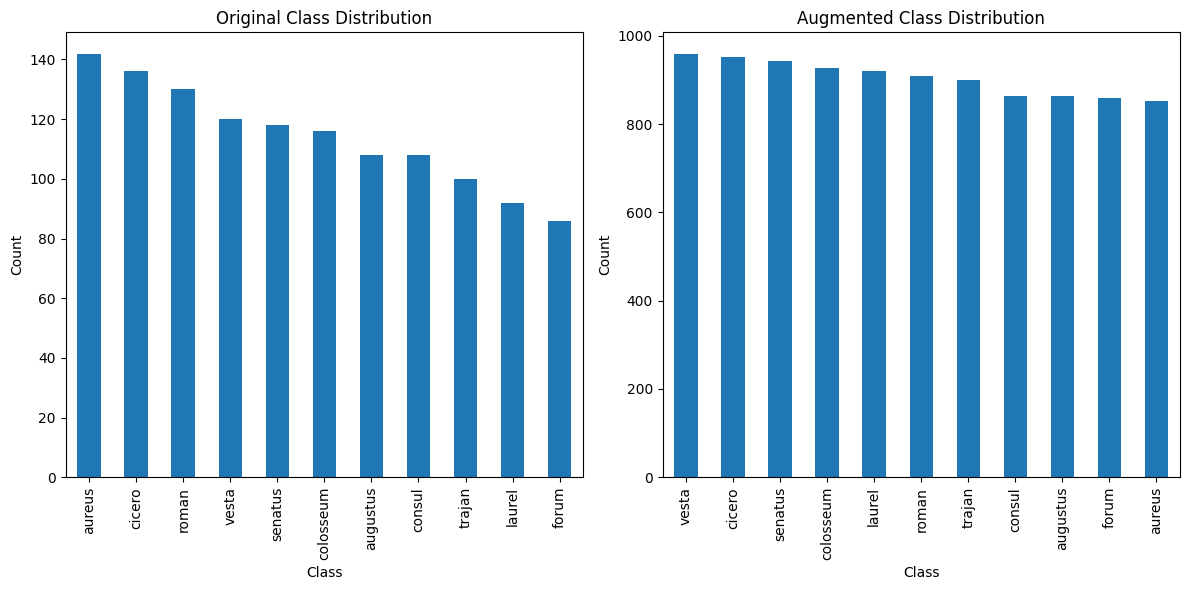

Original class distribution:
Type
aureus       142
cicero       136
roman        130
vesta        120
senatus      118
colosseum    116
augustus     108
consul       108
trajan       100
laurel        92
forum         86
Name: count, dtype: int64

Augmented class distribution:
Type
vesta        960
cicero       952
senatus      944
colosseum    928
laurel       920
roman        910
trajan       900
consul       864
augustus     864
forum        860
aureus       852
Name: count, dtype: int64

Data multiplication factor: 7.93x


In [36]:
# Analyze class distribution before and after augmentation
original_class_dist = df['Type'].value_counts()
augmented_class_dist = all_images_df['Type'].value_counts()

plt.figure(figsize=(12, 6))

# Original distribution
plt.subplot(1, 2, 1)
original_class_dist.plot(kind='bar')
plt.title('Original Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Augmented distribution
plt.subplot(1, 2, 2)
augmented_class_dist.plot(kind='bar')
plt.title('Augmented Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Original class distribution:")
print(original_class_dist)
print("\nAugmented class distribution:")
print(augmented_class_dist)
print(f"\nData multiplication factor: {len(all_images_df) / len(df):.2f}x")

9. Saving the Augmented Dataset

Finally, let's ensure our augmented dataset is ready for model training.

In [37]:
# Final check of the augmented dataset
print(f"Total images in augmented dataset: {len(all_images_df)}")
print("\nSample of the augmented dataset:")
print(all_images_df.sample(10))

# Calculate augmentation statistics
aug_stats = {
    'original_count': len(df),
    'augmented_count': len(augmented_image_paths),
    'total_count': len(all_images_df),
    'multiplication_factor': len(all_images_df) / len(df),
    'class_distribution': all_images_df['Type'].value_counts().to_dict(),
    'augmentations_by_class': class_multipliers
}

# Save statistics
with open('../data/augmentation_stats.txt', 'w') as f:
    for key, value in aug_stats.items():
        if key in ['class_distribution', 'augmentations_by_class']:
            f.write(f"{key}:\n")
            for k, v in value.items():
                f.write(f"  {k}: {v}\n")
        else:
            f.write(f"{key}: {value}\n")

print("\nAugmentation completed! The dataset is ready for model training.")

Total images in augmented dataset: 9954

Sample of the augmented dataset:
                                                  Image       Type  Augmented
4816  ../data/img_augmented\colosseum_mens_virtus_le...  colosseum  Augmented
3674  ../data/img_augmented\cicero_flamma_spes_formo...     cicero  Augmented
2608  ../data/img_augmented\aureus_flamma_honestas_c...     aureus  Augmented
4141  ../data/img_augmented\cicero_memoria_gloria_fi...     cicero  Augmented
3751  ../data/img_augmented\cicero_statera_lex_mors_...     cicero  Augmented
3555  ../data/img_augmented\roman_claritas_vigor_tri...      roman  Augmented
2066  ../data/img_augmented\vesta_ventus_decorus_bel...      vesta  Augmented
7265  ../data/img_augmented\laurel_stella_levis_cons...     laurel  Augmented
6291  ../data/img_augmented\consul_voluptas_sapor_vi...     consul  Augmented
4634  ../data/img_augmented\colosseum_cor_figura_for...  colosseum  Augmented

Augmentation completed! The dataset is ready for model training.


This notebook implements a comprehensive data augmentation pipeline for image classification. We've applied various transformations to make our model more robust to different image variations it might encounter in real-world scenarios. The augmented dataset now contains both original and transformed images, significantly increasing the amount of training data available without collecting additional samples.